In [1]:
!pip install "tensorflow-gpu>=1.15.2,<2.0" ampligraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 411.0 MB 23 kB/s 
     |████████████████████████████████| 168 kB 51.4 MB/s 
     |████████████████████████████████| 50 kB 4.3 MB/s 
     |████████████████████████████████| 503 kB 19.3 MB/s 
     |████████████████████████████████| 20.1 MB 1.4 MB/s 
     |████████████████████████████████| 2.9 MB 43.3 MB/s 
     |████████████████████████████████| 3.8 MB 25.7 MB/s 
     |████████████████████████████████| 6.4 MB 27.8 MB/s 
     |████████████████████████████████| 61 kB 552 kB/s 
     |████████████████████████████████| 500 kB 70.7 MB/s 
     |████████████████████████████████| 2.7 MB 50.2 MB/s 
     |████████████████████████████████| 120 kB 72.0 MB/s 
     |████████████████████████████████| 561 kB 53.3 MB/s 
     |████████████████████████████████| 61 kB 619 kB/s 
     |████████████████████████████████| 61 kB 607 kB/s 
     |████████████████████████████████|

In [2]:
!pip install adjustText

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7097 sha256=3b6eda6ca61f3367618895b574b05c5fd3d642424bb85020754002050c97a60b
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText


In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Train set size:  (1592, 3)
Test set size:  (666, 3)


Average ComplEx Loss:   0.675390: 100%|██████████| 200/200 [00:30<00:00,  6.60epoch/s]

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.



100%|██████████| 666/666 [00:01<00:00, 429.52it/s]


MRR: 0.03
MR: 1237.51
Hits@10: 0.02
Hits@3: 0.02
Hits@1: 0.02


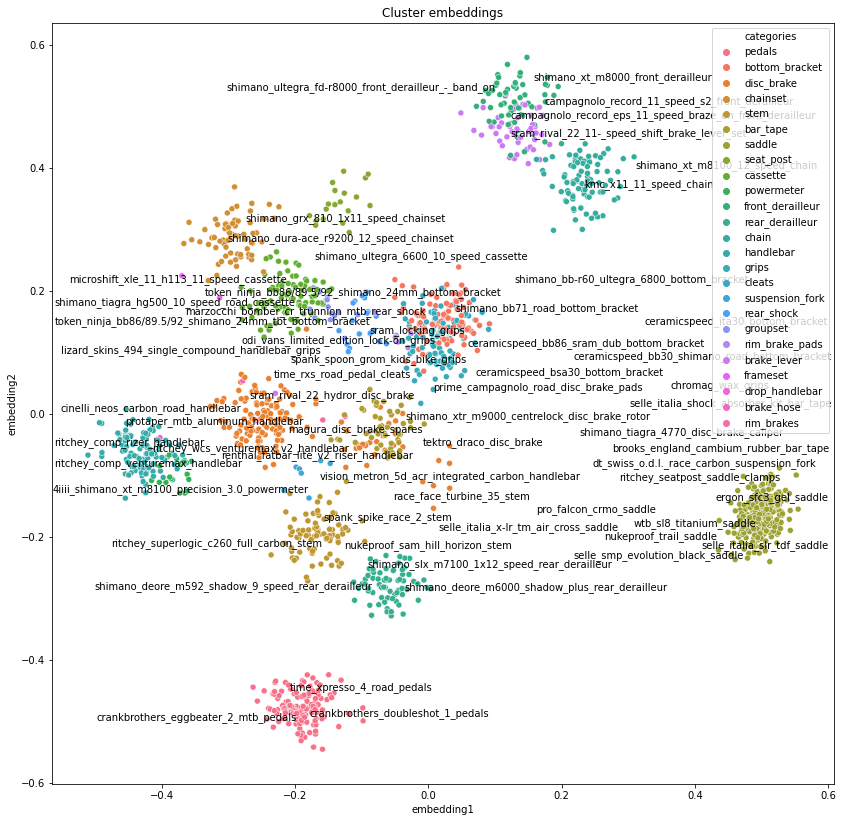

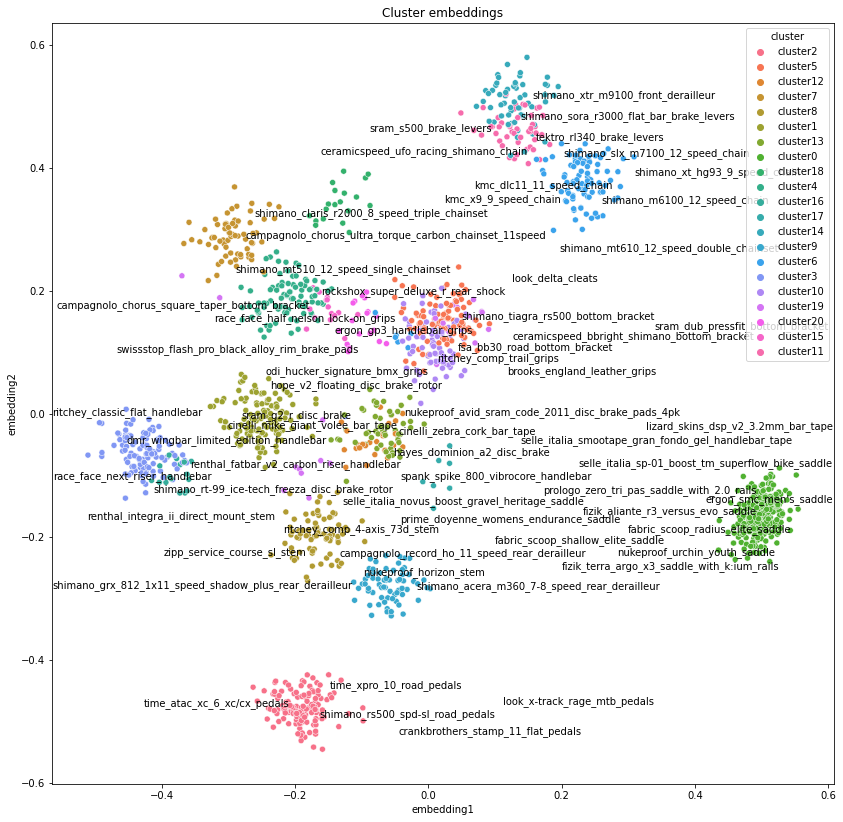

In [4]:
from ampligraph.evaluation import evaluate_performance
from ampligraph.utils import save_model, restore_model
from rdflib import Graph, URIRef
from ampligraph.evaluation import train_test_split_no_unseen
import numpy as np
import pandas as pd
import tensorflow as tf
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
from ampligraph.latent_features import ComplEx
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import pickle


def make_triplets():
    ont_uri = "urn:bike"
    # Create a Graph
    g = Graph()

    # Parse in an RDF file
    g.parse("/content/drive/MyDrive/ont/ont_populated_full.owl", format="turtle")

    triples_list = []
    for subject, predicate, triple_object in g.triples((None, None, None)):
        if predicate.startswith(URIRef(ont_uri + '#hasCategorie')):
            triples_list.append([ent.replace(ont_uri + "#", "") for ent in [subject, predicate, triple_object]])

    df = pd.DataFrame(triples_list, columns=['Subject', 'Predicate', 'Object'])

    return df, triples_list


def split_train_test(triples):
    X_train, X_test = train_test_split_no_unseen(np.array(triples), test_size=0.4, allow_duplication=True)
    print('Train set size: ', X_train.shape)
    print('Test set size: ', X_test.shape)
    return X_train, X_test


def build_model(X_train, X_test):
    mdl = ComplEx(batches_count=50,
                  epochs=200,
                  k=12,
                  eta=20,
                  optimizer='adam',
                  optimizer_params={'lr': 1e-4},
                  loss='multiclass_nll',
                  regularizer='LP',
                  regularizer_params={'p': 3, 'lambda': 1e-5},
                  seed=0,
                  verbose=True)

    mdl.fit(X_train)

    filter_triples = np.concatenate((X_train, X_test))
    ranks = evaluate_performance(X_test,
                                 model=mdl,
                                 filter_triples=filter_triples,
                                 use_default_protocol=True,
                                 verbose=True)
    mr = mr_score(ranks)
    mrr = mrr_score(ranks)

    print("MRR: %.2f" % (mrr))
    print("MR: %.2f" % (mr))

    hits_10 = hits_at_n_score(ranks, n=10)
    print("Hits@10: %.2f" % (hits_10))
    hits_3 = hits_at_n_score(ranks, n=3)
    print("Hits@3: %.2f" % (hits_3))
    hits_1 = hits_at_n_score(ranks, n=1)
    print("Hits@1: %.2f" % (hits_1))
    save_model(mdl, model_name_path="/content/drive/MyDrive/ont/trained_model_category")

categories_t = [ 
      ("saddle", 0),
      ("seat post", 0),
      ("cleats", 1),
      ("powermeter", 0),
      ("frameset", 0),
      ("brake lever", 0),
      ("brake hose", 0),
      ("rim brakes", 0),
      ("rim brake pads", 0),
      ("disc brake", 0),
      ("disc brake pads", 0),
      ("disc brake rotor", 0),
      ("groupset", 0),
      ("front derailleur", 0),
      ("chainset", 0),
      ("bottom bracket", 1),
      ("cassette", 1),
      ("rear derailleur", 1),
      ("chain", 1),
      ("drop handlebar", 0),
      ("handlebar", 1),
      ("bar tape", 1),
      ("grips", 1),
      ("stem", 1),
      ("suspension fork", 0),
      ("rear shock", 0),
      ("pedals", 1)
]

def createUri(v):
    s = v.replace(' ', '_').replace('(', '').replace(')', '').replace('"', "").replace("^", "").replace("\\", "").replace("%", "")
    # .replace("'", "")
    return URIRef(s.encode("ascii", "ignore").decode())

def convert(s, categories, input_df):
    cat = input_df.loc[input_df['title'].str.lower() == s.replace('_', ' ')].categorie.unique()[0]
    return cat

def clustering(df, hue):
    input_df = pd.read_csv('/content/drive/MyDrive/ont/dataframe.csv')
    mdl = restore_model("/content/drive/MyDrive/ont/trained_model_category")
    names = [e.replace(' ', '_') for e in input_df.title.str.lower().tolist()]
    categories = [cat[0].replace(' ', '_') for cat in categories_t]

    parts = df.Subject[df.Subject.isin(names)].unique()

    parts_embeddings = dict(zip(parts, mdl.get_embeddings(parts)))
    parts_embeddings_array = np.array([i for i in parts_embeddings.values()])

    embeddings_2d = PCA(n_components=2).fit_transform(parts_embeddings_array)

    # Find clusters of embeddings using KMeans
    clustering_algorithm = KMeans(n_clusters=21, n_init=25, max_iter=100, random_state=0)
    clusters = find_clusters(parts, mdl, clustering_algorithm, mode='entity')

    # Plot results
    df = pd.DataFrame({"parts": parts, "clusters": "cluster" + pd.Series(clusters).astype(str),
                       "embedding1": embeddings_2d[:, 0], "embedding2": embeddings_2d[:, 1],
                       "categories": pd.Series(parts).apply(lambda c: convert(c, categories, input_df)),
                        "cluster": "cluster" + pd.Series(clusters).astype(str)}) 
    plt.figure(figsize=(14, 14))
    plt.title("Cluster embeddings")

    ax = sns.scatterplot(data=df[df.categories!="unk"], x="embedding1", y="embedding2", hue=hue)

    texts = []
    for i, point in df.iterrows():
        if np.random.uniform() < 0.04:
            texts.append(plt.text(point['embedding1'] + .02, point['embedding2'], str(point['parts'])))
    adjust_text(texts)
    plt.show()

build_model(*split_train_test(make_triplets()[1]))
clustering(make_triplets()[0], 'categories')
clustering(make_triplets()[0], 'cluster')